# Constructing the head model

This section will cover how to contruct the head model (the forward model) to be used in source modeling. This will done based on the structural T1 MRI. The models will be alinged to head postion of the subject in the MEG system. Note that this seciton requires access to FreeSurfer (a Unix/Linux software). For more details see https://mne.tools/stable/auto_tutorials/forward/30_forward.html

## Preparation

Import the relevant Python modules:

In [1]:
import os.path as op
import mne

Then set the file names and paths:

In [10]:
raw_fname = r'D:\FLUX\data\training_raw-1.fif'
mri_dir = r'D:\FLUX\data\MRIs\subjects'
subject = 'training1'  

## Perform surface reconstruction using FreeSurfer and MNE:

A first requirement is that the MRI data are in NifTI (.nii) format. Converion from DICOM  to NifTI can be done e.g. using [MRIcro](https://people.cas.sc.edu/rorden/mricro/mricro.html)
The NifTI file for this tutorial is *T1_anon_defaced.nii* . Its the T1 MRI which has been 'de-faced' in order to anonymize the data. 

[FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) provides the functionality for performing the cortical reconstuction using the [recon-all](https://surfer.nmr.mgh.harvard.edu/fswiki/recon-all/). 

This must be done in Unix/Linux:

> recon-all -i T1_anon_defaced.nii -s T1_anon_defaced -all


To perform the scalp surface reconstruction to be used in MNE-Python using the command from the terminal:

> mne make_scalp_surfaces --overwrite --subject T1_anon_defaced --force


To create the BEM, execute the terminal command:

> mne watershed_bem --overwrite --subject t1_anon_defaced
    
For a convinient batch script performing these commands see *my_recon.sh* in GitHub 
    

Now read and illustrate the brain surface generated from FreeSurfer: 

## Inspecting the surface reconstruction

In order to verify that the surface has been constructed and the fif-file created plot the output:

In [3]:
Brain = mne.viz.get_brain_class()

brain = Brain(subject, 
                  hemi='lh', 
                  surf='pial',
                  subjects_dir=mri_dir, 
                  size=(800, 600))

brain.add_annotation('aparc.a2009s', borders=False)

Using pyvista 3d backend.



C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(



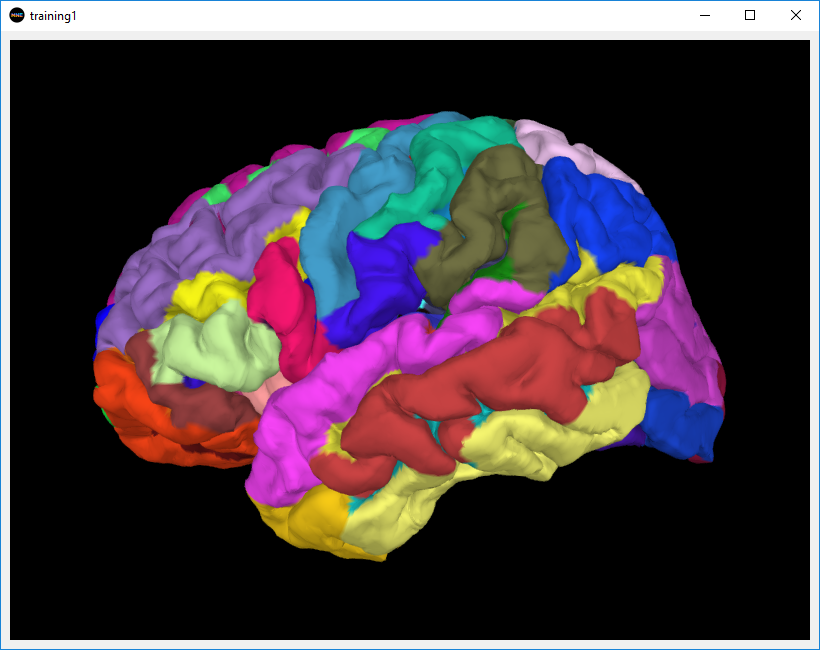

## Creating the boundary element model (BEM) surfaces

Now that the surface of the MRI has been recontructed the boundary element model (BEM) surface can be created. As this will be used for MEG source reconstruction, we will prepare a single shell model by settimng *conductivity = (0.3,)* . the *ico* parameter serves to downsample the model and can be increased to reduce the computational demands. 

In [4]:
conductivity = (0.3,) 
model = mne.make_bem_model(subject,
                           ico=4,
                           conductivity=conductivity,
                           subjects_dir=mri_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -0.22 -26.75  24.03 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


Now save the BEM model

In [5]:
fname_bem = 'training1-bem-sol.fif' 
mne.write_bem_solution(op.join(mri_dir,fname_bem),
                           bem,
                           overwrite=True)
    # To visualize the BEM:


Overwriting existing file.


and visualize

Using surface: D:\FLUX\data\MRIs\subjects\training1\bem\inner_skull.surf
Using surface: D:\FLUX\data\MRIs\subjects\training1\bem\outer_skull.surf
Using surface: D:\FLUX\data\MRIs\subjects\training1\bem\outer_skin.surf


C:\Users\Ole\.conda\envs\mne\lib\site-packages\mne\viz\utils.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


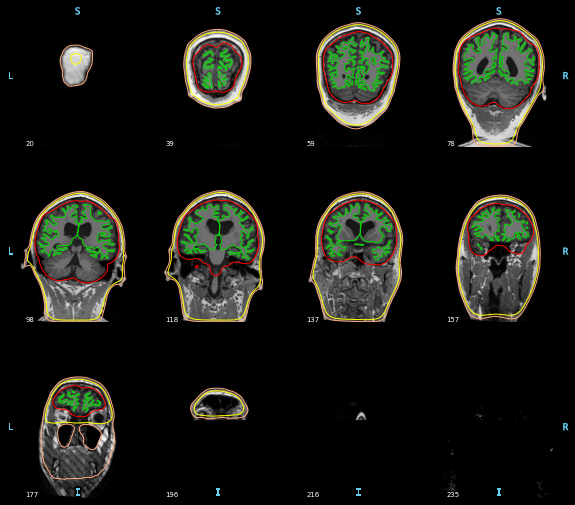

In [8]:
mne.viz.plot_bem(subject=subject,
                subjects_dir=mri_dir,
                brain_surfaces='white',
                orientation='coronal');

## Co-registration with anatomical landmars 

The next step involves the spatial alignment of MEG sensor space in relation to digitized scalp landmarks,the HPI coils and the MRI volumes. This alignment is used when deriving the forward solution. I requires working with the MNE-Python-coregistration GUI software. Some further support can be found here: https://www.slideshare.net/mne-python/mnepython-coregistration

In [3]:
mne.gui.coregistration()

    Triangle neighbors and vertex normals...
    Triangle neighbors and vertex normals...
Coregistration: Excluding 0 head shape points with distance >= inf m.
Coregistration: Excluding 55 head shape points with distance >= 0.010 m.


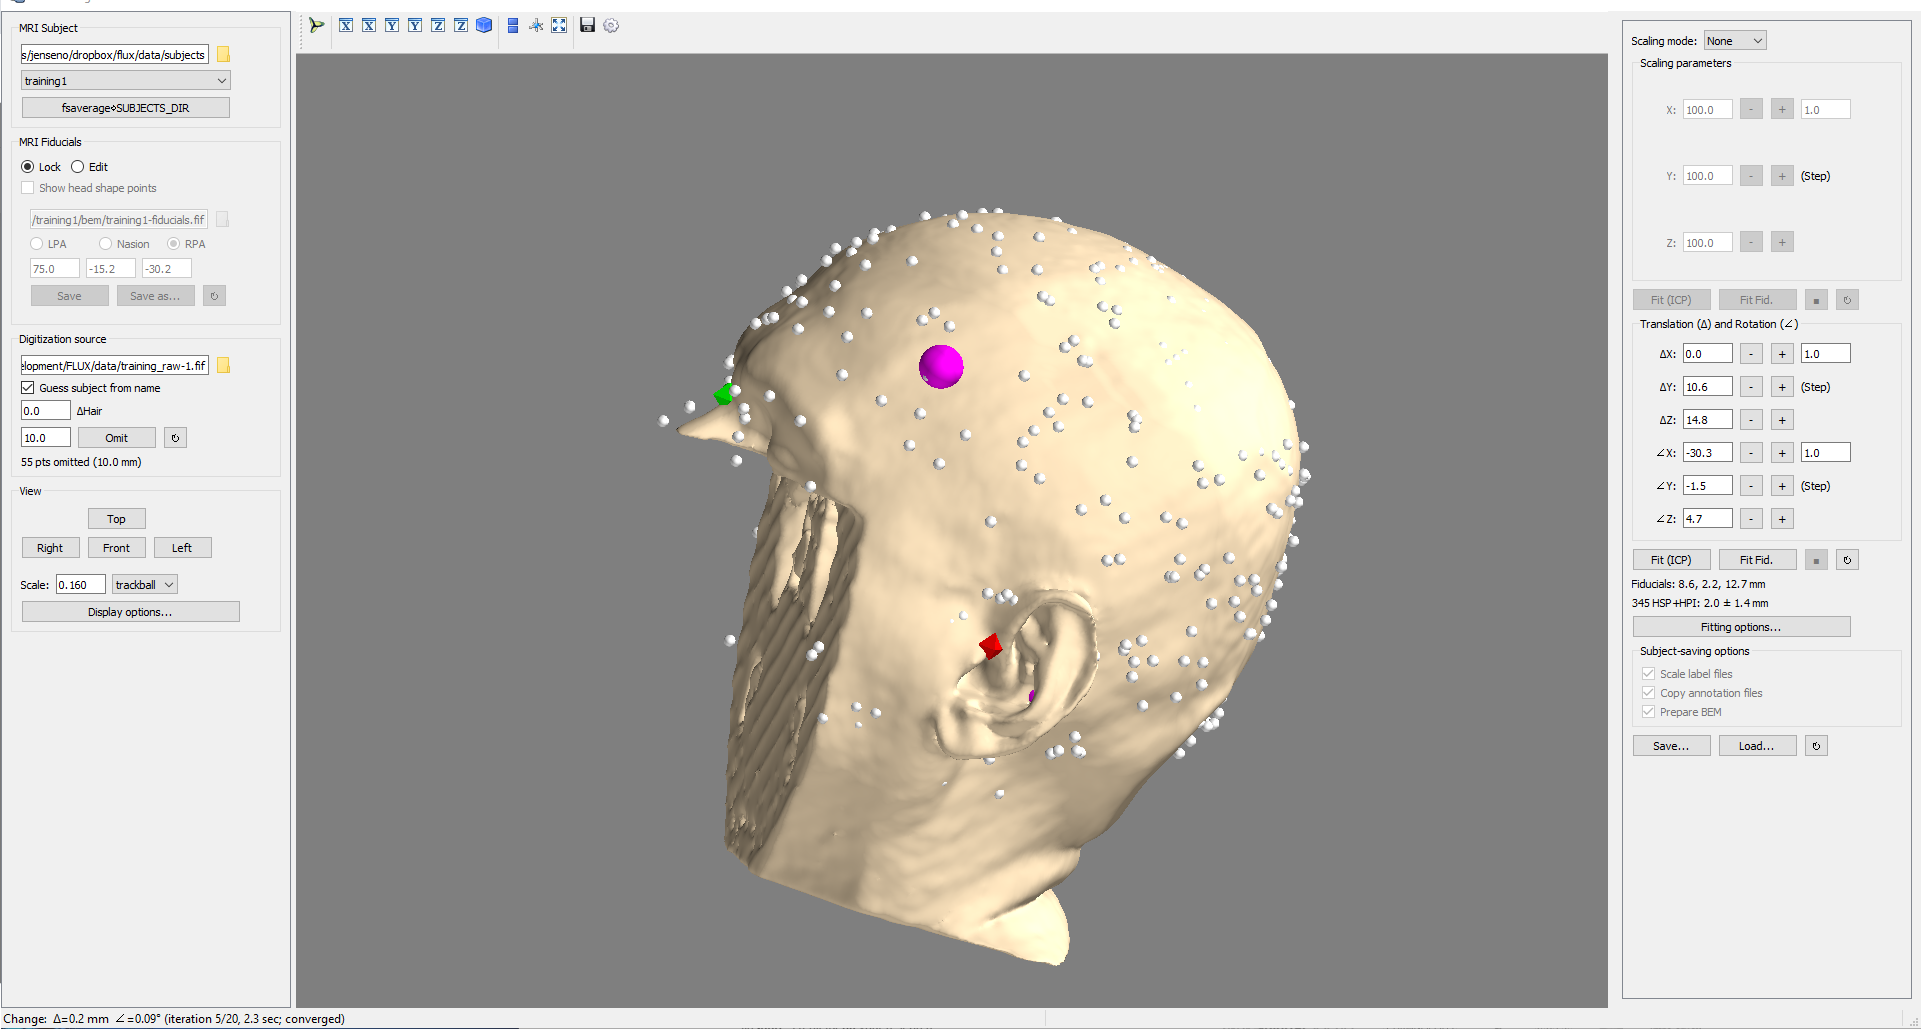

Note that we here set 'Omit' to 10 mm. This means that points with a distance 10 mm away from the surface are ignored. This is essential for the de-faced MRI.

Next, its important to varify the alignment with respect to the MEG sensor array:


In [12]:
trans = r'D:\FLUX\data\training1-trans.fif'
info = mne.io.read_info(raw_fname)
mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
                           meg=['helmet', 'sensors'], subjects_dir=mri_dir,
                           surfaces='head-dense')

    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
Using lh.seghead for head surface.
Getting helmet for system 306m


C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
C:\Users\Ole\.conda\envs\mne\lib\site-packages\pyvista\core\dataset.py:1192: Pyv

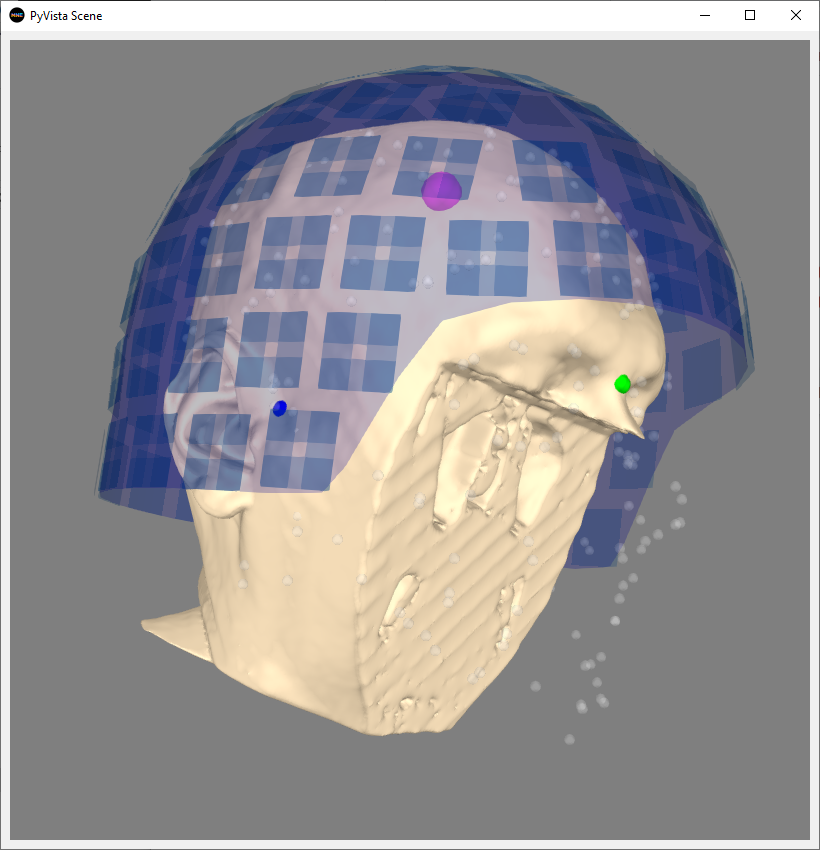

Here its important to check that the fiducial points by the nasium and the preauriculars are well placed. 

## Computing the sources according to the BEM model

To eventually construct the surface constrained forward model, the source space must be derived: 

In [21]:
spacing='oct6'  # 4098 sources per hemisphere, 4.9 mm spacing
src = mne.setup_source_space(subject,
            spacing=spacing,
            add_dist='patch',
            subjects_dir=mri_dir)


# volume
#  surface = op.join(subjects_dir, subject, 
#                          'bem', 'inner_skull.surf')
#        src = mne.setup_volume_source_space(subject, 
#                                            subjects_dir=subjects_dir,
#                                            surface=surface,
#                                            # mri=mrifile,  #TODO: what is it needed for? For interpolation. Is it required??? Note that MRI can only be .mgh or .mgz
#                                            # mindist=2.5,  #TODO: check these settings
#                                            # exclude=10.0, 
#                                            verbose=True)
#       # Set filename
#        fname_src = '%s-volume_src.fif' % (subject)



Setting up the source space with the following parameters:

SUBJECTS_DIR = D:\FLUX\data\MRIs\subjects
Subject      = training1
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading D:\FLUX\data\MRIs\subjects\training1\surf\lh.white...
Mapping lh training1 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\FLUX\data\MRIs\subjects\training1\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/136119 selected to source space (oct = 6)

Loading D:\FLUX\data\MRIs\subjects\training1\surf\rh.white...
Mapping rh training1 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\FLUX\data\MRIs\subjects\training1\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/137489 selected to source space (oct = 6)

Calculating patch information (limit=0.0 mm)...
    Computin

and then save it 

In [22]:
fname_src = 'training1-surfaceoct6_src.fif' 
mne.write_source_spaces(op.join(mri_dir,fname_src),
                            src,
                            overwrite=True)

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


To visualize the source set write:

Using surface: D:\FLUX\data\MRIs\subjects\training1\bem\inner_skull.surf
Using surface: D:\FLUX\data\MRIs\subjects\training1\bem\outer_skull.surf
Using surface: D:\FLUX\data\MRIs\subjects\training1\bem\outer_skin.surf


C:\Users\Ole\.conda\envs\mne\lib\site-packages\mne\viz\utils.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


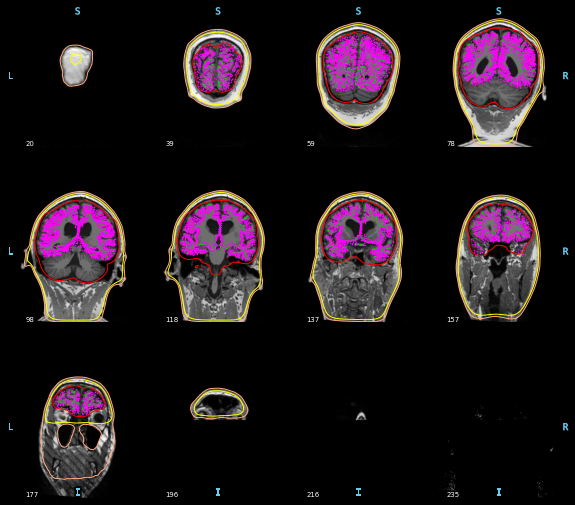

In [24]:
mne.viz.plot_bem(subject=subject, 
                     subjects_dir=mri_dir,
                     brain_surfaces='white', 
                     src=src, 
                     orientation='coronal');

## Construting the forward model

The last step is to construct the forward model be assining a lead-field to each source location:

In [25]:
fwd = mne.make_forward_solution(raw_fname, 
                                    trans=trans, 
                                    src=src, 
                                    bem=bem,
                                    meg=True, eeg=False, 
                                    mindist=5.,  #TODO: minimum distance of sources from inner skull surface (in mm); can be 2.5
                                    verbose=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=136119, n_used=4098>, <surface (rh), n_vertices=137489, n_used=4098>] MRI (surface RAS) coords, subject 'training1', ~25.2 MB>
MRI -> head transform : D:\FLUX\data\training1-trans.fif
Measurement data      : training_raw-1.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.996247 -0.058107 -0.064149       0.04 mm
     0.082510  0.861462  0.501074      10.55 mm
     0.026146 -0.504486  0.863024      14.78 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
99 coil definitions read
Coordinate transformation: MEG device -> head
     0.995222 -0.089575 -0.038852      -1.12 mm
     0.095761  0.973127  0.209411      -7.35 mm
     0.019051 -0.212131  0.977056      39.69 mm
     0.000000  0.0

Finally, save the forward models:

In [26]:
fname_fwd = op.join(mri_dir,
                        subject+'-surface_fwd.fif' )

mne.write_forward_solution(fname_fwd,
                               fwd,
                               overwrite=True)

Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


To inspect the model extract a few parameters.

Number of vertices:

In [30]:
fwd["src"]

<SourceSpaces: [<surface (lh), n_vertices=136119, n_used=4097>, <surface (rh), n_vertices=137489, n_used=4098>] head coords, subject 'training1', ~25.2 MB>

The lead field is defined by the number of sensors and sources:

In [31]:
leadfield = fwd['sol']['data']
leadfield.shape

(306, 24585)

## Preregistraion and publications